In [1]:
#Importing necessary dependencies
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from numpy import dstack
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
#Loading dataset
d1 = pd.read_csv('/content/UNSW_NB15_training-set.csv')
t1 = pd.read_csv('/content/UNSW_NB15_testing-set.csv')

In [3]:
data = d1.append(t1, ignore_index = True)

In [4]:
from sklearn import preprocessing
data.drop(columns = 'label', inplace = True)
multic = pd.DataFrame(data.attack_cat)
le2 = preprocessing.LabelEncoder()
enc_label = multic.apply(le2.fit_transform)
data['attax'] = enc_label

In [5]:
data.attack_cat.value_counts()

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

In [6]:
categorical_features = ['proto', 'service', 'state']
label_feature = ['attack_cat', 'attax']

In [7]:
drop_features = ['id', 'sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
numerical_features = list(set(data.columns) - set(label_feature) - set(categorical_features) - set(drop_features))

In [8]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

In [9]:
data.drop(columns = categorical_features, inplace = True)

In [10]:
data.dropna(inplace=True)

In [11]:
data.reset_index(drop=True, inplace=True)

In [12]:
Y = data['attax']
X = data.drop(columns = ['attax', 'attack_cat'], axis = 1)

In [13]:
!pip install tab2img
from tab2img.converter import Tab2Img

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
scaler = preprocessing.MinMaxScaler().fit(X)
X_scaled_train = scaler.transform(X)
y_scaler =  preprocessing.StandardScaler().fit(Y.values.reshape(-1, 1))
y_scaled_train = y_scaler.transform(Y.values.reshape(-1, 1))

In [15]:
model = Tab2Img()
#train_images = model.fit_transform(X, Y)

In [16]:
train_images = model.fit_transform(X_scaled_train, y_scaled_train)

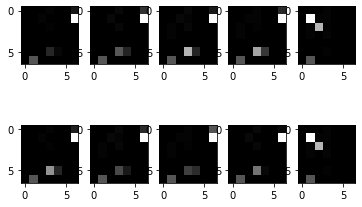

In [17]:
from PIL import Image
fig,ax = plt.subplots(2,5)
for i in range(10):
    nparray = train_images[i]
    image = Image.fromarray(nparray * 255)
    ax[i%2][i//2].imshow(image)
fig.show()

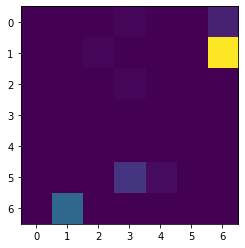

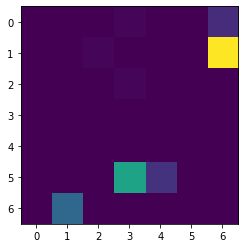

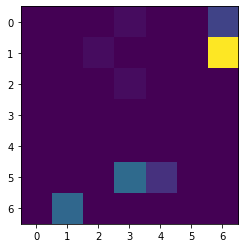

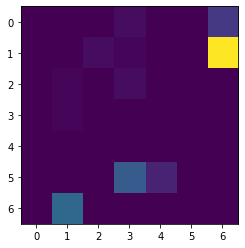

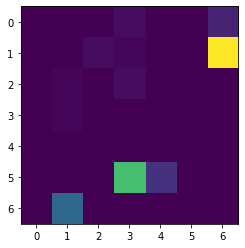

In [18]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.imshow(train_images[i], interpolation='nearest')
    plt.show()

In [19]:
from tensorflow.keras import Model, optimizers
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
import sklearn
from sklearn.model_selection import train_test_split

In [20]:
Y.value_counts()

6    93000
5    58871
3    44525
4    24246
2    16353
7    13987
0     2677
1     2329
8     1511
9      174
Name: attax, dtype: int64

In [21]:
new_shape = (train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
Y = tf.keras.utils.to_categorical(Y)
train_images = train_images.reshape(new_shape)

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(train_images, Y, random_state=10, test_size=0.2)

In [23]:
input_shape = (7,7,1)
num_classes = 10

In [24]:
#Evaluation Metrics
class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        
        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
        self.negatives.assign_add(negatives)
        
        y_pred = tf.greater_equal(y_pred, 0.5)
        
        false_positive_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)) 
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)
        
        false_positives = tf.reduce_sum(false_positive_values)
        
        self.false_positives.assign_add(false_positives)
        
    def result(self):
        return tf.divide(self.false_positives, self.negatives)

In [25]:
#Evaluation Metrics
def plot_loss(model_history):
  train_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][0]
  valid_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(train_loss, '--', color=color, label='Train Loss')
  ax1.plot(valid_loss, color=color, label='Valid Loss')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Loss')
  plt.show()

In [26]:
#Evaluation Metrics
def plot_model_recall_fpr(model_history):
  train_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][0]
  valid_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][1]
  train_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][0]
  valid_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][1]
  fig, ax1 = plt.subplots()
  color = 'tab:red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Recall', color=color)
  ax1.set_ylim([-0.05,1.05])
  ax1.plot(train_recall, '--', color=color, label='Train Recall')
  ax1.plot(valid_recall, color=color, label='Valid Recall')
  ax1.tick_params(axis='y', labelcolor=color)
  plt.legend(loc='upper left')
  plt.title('Model Recall and FPR')
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('False Positive Rate', color=color)  # we already handled the x-label with ax1
  ax2.plot(valid_fpr, color=color, label='Valid FPR')
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim([-0.05,1.05])
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.legend(loc='upper right')
  plt.show()

In [27]:
#Evaluation Metrics
def plot_train_history(history):
    # plot the cost and accuracy 
    loss_list = history['loss']
    val_loss_list = history['val_loss']
    accuracy_list = history['accuracy']
    val_accuracy_list = history['val_accuracy']
    # epochs = range(len(loss_list))

    # plot the cost
    plt.plot(loss_list, 'b', label='Training cost')
    plt.plot(val_loss_list, 'r', label='Validation cost')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title('Training and validation cost')
    plt.legend()

    plt.figure()
    
    # plot the accuracy
    plt.plot(accuracy_list, 'b', label='Training accuracy')
    plt.plot(val_accuracy_list, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('iterations')
    plt.title('Training and validation accuracy')
    plt.legend()

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
model = densenet(input_shape,num_classes)

In [29]:
model.compile(optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy', FalsePositiveRate(), tf.keras.metrics.Recall()])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 7, 1)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 4, 4, 64)     3200        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 2, 2, 64)     0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 2, 2, 64)    256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

In [31]:
history = model.fit(x=train_images, y=Y, batch_size=500, epochs = 30, validation_split = 0.2, verbose=1).history

Epoch 1/30
413/413 [==============================] - 795s 2s/step - loss: 0.6742 - accuracy: 0.7401 - false_positive_rate: 0.0129 - recall: 0.6488 - val_loss: 2.6152 - val_accuracy: 0.1074 - val_false_positive_rate: 0.0141 - val_recall: 0.0221
Epoch 2/30
413/413 [==============================] - 756s 2s/step - loss: 0.5641 - accuracy: 0.7818 - false_positive_rate: 0.0112 - recall: 0.6988 - val_loss: 0.5703 - val_accuracy: 0.8294 - val_false_positive_rate: 0.0095 - val_recall: 0.8019
Epoch 3/30
413/413 [==============================] - 757s 2s/step - loss: 0.5257 - accuracy: 0.7980 - false_positive_rate: 0.0107 - recall: 0.7225 - val_loss: 0.6181 - val_accuracy: 0.8510 - val_false_positive_rate: 0.0120 - val_recall: 0.8270
Epoch 4/30
413/413 [==============================] - 756s 2s/step - loss: 0.5106 - accuracy: 0.8048 - false_positive_rate: 0.0100 - recall: 0.7308 - val_loss: 1.6661 - val_accuracy: 0.6323 - val_false_positive_rate: 0.0198 - val_recall: 0.5702
Epoch 5/30
413/413 [

In [32]:
test_results1 = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test results1 -  Accuracy: {test_results1[1]*100}')

1611/1611 [==============================] - 57s 36ms/step - loss: 0.5379 - accuracy: 0.8155 - false_positive_rate: 0.0121 - recall: 0.7659
Test results1 -  Accuracy: 81.54846429824829


MODEL - 1


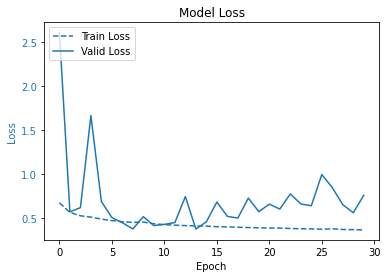

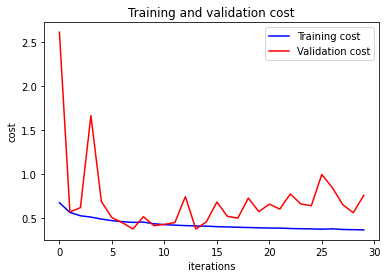

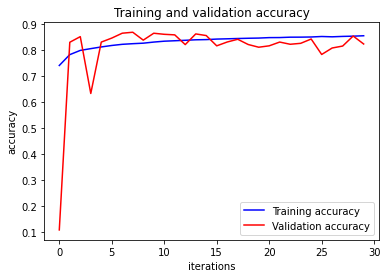

In [33]:
print("MODEL - 1")
plot_loss(history)
plot_train_history(history)